In [ ]:
from quchem.Graph import *

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
from quchem.Hamiltonian_Generator_Functions import *


### Parameters
Molecule = 'H2'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
num_shots = 10000
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')

In [ ]:
QubitHamiltonianFrozen = tuple(frozenset((PauliStr, const) for op in QubitHamiltonian \
                                              for PauliStr, const in op.terms.items()))

## OpenFermion_Commutativity

In [3]:
def OpenFermion_Commutativity(QubitOp_1, QubitOp_2, Comm_flag):
    """

     Find if two PauliWords either commute or anti_commute.
     By default it will check if they commute.

    Args:
        QubitOp_1 ( openfermion.ops._qubit_operator.QubitOperator): First PauliWord to compare
        QubitOp_2 ( openfermion.ops._qubit_operator.QubitOperator): Second PauliWord to compare
        Comm_flag (str): flags to find either:
                                                   qubit wise commuting (QWC) terms  -> flag = 'QWC',
                                                                     commuting terms -> flag = 'C',
                                                                anti-commuting terms -> flag = 'AC'

    Returns:
        (bool): True or false as to whether terms commute or anti_commute

    """
    
    if Comm_flag == 'C':
        return QubitOp_1*QubitOp_2==QubitOp_2*QubitOp_1
    elif Comm_flag == 'AC':
        return QubitOp_1*QubitOp_2== -QubitOp_2*QubitOp_1
    elif Comm_flag == 'QWC':
        qNos_Op1,qOps_Op1 = list(zip(*[Paulistrs for Paulistrs, const in QubitOp_1.terms.items()][0]))
        qNos_Op2,qOps_Op2 = list(zip(*[Paulistrs for Paulistrs, const in QubitOp_2.terms.items()][0]))
        
        common_qubits = np.intersect1d(qNos_Op1, qNos_Op2)
        
        PauliStr_Op1_common = np.take(qOps_Op1, np.where(np.isin(qNos_Op1, common_qubits) == True)).flatten()
        PauliStr_Op2_common = np.take(qOps_Op2, np.where(np.isin(qNos_Op2, common_qubits) == True)).flatten()
        
        commutativity_check = np.array([1 if Pauli_op1_common == PauliStr_Op2_common[index] else -1
                                    for index, Pauli_op1_common in enumerate(PauliStr_Op1_common)])
        if bool(np.all([x == 1 for x in commutativity_check])) is True:
            return True
        else:
            return False
        
    else:
        raise ValueError('unknown commutation flag')


In [4]:
from openfermion.ops import QubitOperator
class My_QubitOperator(QubitOperator):
    def __hash__(self):
        
        qubit_operations = list(self.terms.keys())
        
        if qubit_operations[0]:
            return hash(tuple(qubit_operations + list(self.terms.values())))
        else:
            return hash(tuple(['Identity_operation'] + list(self.terms.values())))
            
    def Get_Operator_str(self, seperator=' '):
        
        qubit_operations = list(self.terms.keys())
    
        if qubit_operations[0]:
            qNos, qStrs = list(zip(*list(self.terms.keys())[0]))
            PauliWord = [qStrs[index]+str(qNo)for index, qNo in enumerate(qNos)]
        else:
            PauliWord= ['I']
        return seperator.join(PauliWord)
    
Op1 = My_QubitOperator('X2 Y3', -0.5)

print(Op1.Get_Operator_str(seperator=' '))

hash(Op1)

X2 Y3


-4857856794148012338

In [5]:
from openfermion.ops import QubitOperator
Op1 = My_QubitOperator('Y0 X1 X2 X3', 0.5)

Op2 = My_QubitOperator('Y0 X1 X2 Z3', 0.25j)

comm_status = 'AC'

OpenFermion_Commutativity(Op1, Op2, comm_status)

True

## Openfermion_Build_Graph_Nodes

In [6]:
def Openfermion_Build_Graph_Nodes(List_of_nodes, Graph, plot_graph=False):
    """

    Function builds nodes of graph with attributes

    Args:
        TODO

    Returns:



    """
    labels={}
    node_list=[]
    for node in List_of_nodes:
        Graph.add_node(node)

        if plot_graph is True:
            node_list.append(node)
    
            PauliWord_str = node.Get_Operator_str(seperator='')
            labels[node] = ' '.join(PauliWord_str)

    if plot_graph is True:
        plt.figure()

        pos = nx.circular_layout(Graph)

        nx.draw_networkx_nodes(Graph, pos,
                               nodelist=node_list,
                               node_color='r',
                               node_size=500,
                               alpha=0.8)

        nx.draw_networkx_labels(Graph, pos, labels)  # , font_size=8)
        plt.show()
    return Graph

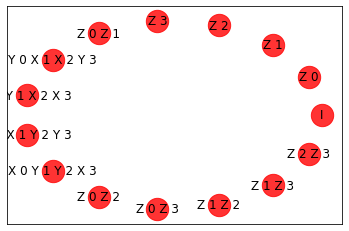

In [7]:
G = nx.Graph()

My_Hamiltonian = [My_QubitOperator(strings,const) for qubitOp in QubitHamiltonian for strings,const in qubitOp.terms.items()]

G = Openfermion_Build_Graph_Nodes(My_Hamiltonian, G, plot_graph=True)

## Openfermion_Build_Graph_Edges_COMMUTING_QWC_AntiCommuting

In [8]:
def Openfermion_Build_Graph_Edges_COMMUTING_QWC_AntiCommuting(Graph, List_of_nodes, anti_comm_QWC, plot_graph = False):
    """

    Function builds graph edges for commuting / anticommuting / QWC PauliWords

    Args:
        PauliWord_string_nodes_list (list): list of PauliWords (str)
        Graph: networkX graph with nodes already defined
        anti_comm_QWC (str): flags to find either:
                                           qubit wise commuting (QWC) terms  -> flag = 'QWC',
                                                             commuting terms -> flag = 'C',
                                                        anti-commuting terms -> flag = 'AC'
        plot_graph (optional, bool): whether to plot graph

    Returns:
        Graph: Graph with nodes connected if they commute / QWC / anti-commute

    """
    node_list=[]
    labels={}

    for index, selected_PauliWord in enumerate(tqdm(List_of_nodes, ascii=True, desc='Building Graph Edges')):

        for j in range(index + 1, len(List_of_nodes)):
            comparison_PauliWord = List_of_nodes[j]

            if OpenFermion_Commutativity(selected_PauliWord, comparison_PauliWord, anti_comm_QWC) is True:
                Graph.add_edge(selected_PauliWord, comparison_PauliWord)
            else:
                continue

        if plot_graph is True:
            
            node_list.append(selected_PauliWord)
            selected_PauliWord_str = selected_PauliWord.Get_Operator_str(seperator='')
            labels[selected_PauliWord] = ' '.join(selected_PauliWord_str)

    if plot_graph is True:
        plt.figure()

        pos = nx.circular_layout(Graph)

        nx.draw_networkx_nodes(Graph, pos,
                               nodelist=node_list,
                               node_color='r',
                               node_size=500,
                               alpha=0.8)

        nx.draw_networkx_labels(Graph, pos, labels)  # , font_size=8)
        nx.draw_networkx_edges(Graph, pos, width=1.0, alpha=0.5)
        plt.show()

    return Graph

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 1424.08it/s]


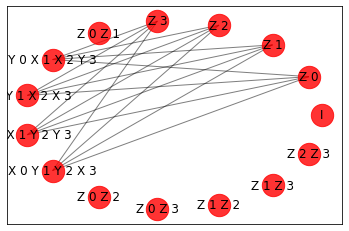

In [11]:
G = nx.Graph()
G = Openfermion_Build_Graph_Nodes(My_Hamiltonian, G, plot_graph=False)

commutativity_flag = 'AC'

G = Openfermion_Build_Graph_Edges_COMMUTING_QWC_AntiCommuting(G, My_Hamiltonian,
                                              commutativity_flag, plot_graph = True)

## Openfermion_Get_Complemenary_Graph

In [12]:
def Openfermion_Get_Complemenary_Graph(Graph, plot_graph=False):

    Complement_Graph = nx.complement(Graph)

    node_list=[]
    labels={}
    if plot_graph is True:
        plt.figure()
        for node in Complement_Graph.nodes:
            
            node_list.append(node)
            PauliWord_str = node.Get_Operator_str(seperator='')
            labels[node] = ' '.join(PauliWord_str)
            

        pos = nx.circular_layout(Complement_Graph)

        nx.draw_networkx_nodes(Complement_Graph, pos,
                               nodelist=node_list,
                               node_color='r',
                               node_size=500,
                               alpha=0.8)

        nx.draw_networkx_labels(Complement_Graph, pos, labels)  # , font_size=8)
        nx.draw_networkx_edges(Complement_Graph, pos, width=1.0, alpha=0.5)
        plt.show()
    return Complement_Graph

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 288.22it/s]


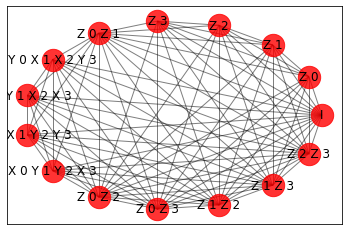

In [13]:
commutativity_flag = 'AC'
G=nx.Graph()
G = Openfermion_Build_Graph_Nodes(My_Hamiltonian, G, plot_graph=False)
G = Openfermion_Build_Graph_Edges_COMMUTING_QWC_AntiCommuting(G, My_Hamiltonian, commutativity_flag, plot_graph = False) 

G_comp = Openfermion_Get_Complemenary_Graph(G, plot_graph=True)

## Openfermion_Get_clique_cover

In [14]:
def Openfermion_Get_clique_cover(Graph, strategy='largest_first', plot_graph=False):
    """
    https: // en.wikipedia.org / wiki / Clique_cover

    Function gets clique cover of a graph. Does this via a graph colouring approach - therefore
    strategy is important here!

    Args:
        Graph (networkx.classes.graph.Graph): networkx graph
        strategy (str): graph colouring method to find clique cover. (note is a heuristic alg)
        plot_graph (optional, bool): whether to plot graph
        node_attributes_dict (dict): Dictionary with nodes as keys and attributes as values

    Returns:
        colour_key_for_nodes (dict): A dictionary containing colours (sets) as keys and item as list of nodes
                                     that are completely connected by edges

    """
    comp_GRAPH = Openfermion_Get_Complemenary_Graph(Graph, plot_graph=False)

    greedy_colouring_output_dic = nx.greedy_color(comp_GRAPH, strategy=strategy, interchange=False)
    unique_colours = set(greedy_colouring_output_dic.values())
    
    colour_key_for_nodes = {}
    for colour in unique_colours:
        colour_key_for_nodes[colour] = [k for k in greedy_colouring_output_dic.keys()
                                        if greedy_colouring_output_dic[k] == colour]

    if plot_graph is True:
        import matplotlib.cm as cm
        colour_list = cm.rainbow(np.linspace(0, 1, len(colour_key_for_nodes)))
        pos = nx.circular_layout(Graph)

        for colour in colour_key_for_nodes:
            nx.draw_networkx_nodes(Graph, pos,
                                   nodelist=[node for node in colour_key_for_nodes[colour]],
                                   node_color=colour_list[colour].reshape([1,4]),
                                   node_size=500,
                                   alpha=0.8)


        # labels = {node: node for node in list(Graph.nodes)}
        labels = {node: node.Get_Operator_str(seperator='') for node in Graph.nodes}

        nx.draw_networkx_labels(Graph, pos, labels)  # , font_size=8)

        nx.draw_networkx_edges(Graph, pos, width=1.0, alpha=0.5)
        plt.show()

    return colour_key_for_nodes

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 1418.98it/s]


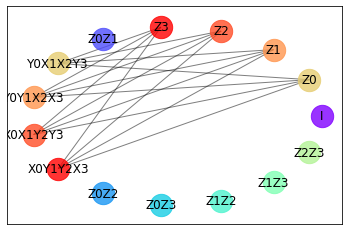

{0: [(-0.09706626861762581+0j) []],
 1: [(0.168688981686933+0j) [Z0 Z1]],
 2: [(0.12062523481381841+0j) [Z0 Z2]],
 3: [(0.16592785032250779+0j) [Z0 Z3]],
 4: [(0.16592785032250779+0j) [Z1 Z2]],
 5: [(0.12062523481381841+0j) [Z1 Z3]],
 6: [(0.1744128761065161+0j) [Z2 Z3]],
 7: [(0.17141282639402383+0j) [Z0], (0.045302615508689394+0j) [Y0 X1 X2 Y3]],
 8: [(0.1714128263940239+0j) [Z1], (-0.045302615508689394+0j) [Y0 Y1 X2 X3]],
 9: [(-0.22343153674663985+0j) [Z2], (-0.045302615508689394+0j) [X0 X1 Y2 Y3]],
 10: [(-0.22343153674663985+0j) [Z3], (0.045302615508689394+0j) [X0 Y1 Y2 X3]]}

In [15]:
commutativity_flag = 'AC'
G=nx.Graph()
G = Openfermion_Build_Graph_Nodes(My_Hamiltonian, G, plot_graph=False)
G = Openfermion_Build_Graph_Edges_COMMUTING_QWC_AntiCommuting(G, My_Hamiltonian, commutativity_flag, plot_graph = False) 


clique = Openfermion_Get_clique_cover(G, strategy='largest_first', plot_graph=True)
clique

## Class operation

In [16]:
class Openfermion_Hamiltonian_Graph():

    def __init__(self, QubitHamiltonian):

        self.QubitHamiltonian = QubitHamiltonian
        self.Graph = nx.Graph()

    def _Get_hashable_Hamiltonian(self):
        # networkX requires hashable object... therefore concert QubitHamiltonian to hashable form

        self.My_QubitHamiltonian = [My_QubitOperator(strings,const) for qubitOp in QubitHamiltonian for strings,const in qubitOp.terms.items()]

    def _Build_Graph_nodes(self, plot_graph=False):

        self.Graph = Openfermion_Build_Graph_Nodes(self.My_QubitHamiltonian, self.Graph, plot_graph=plot_graph)

    def _Build_Graph_edges(self, commutativity_flag, plot_graph=False):

        self.Graph = Openfermion_Build_Graph_Edges_COMMUTING_QWC_AntiCommuting(self.Graph, self.My_QubitHamiltonian,
                                                                               commutativity_flag, plot_graph = plot_graph)

    def _Colour_Graph(self, Graph_colouring_strategy='largest_first', plot_graph=False):

        output_sets = Openfermion_Get_clique_cover(self.Graph, strategy=Graph_colouring_strategy, plot_graph=plot_graph)

        return output_sets

    def Get_Clique_Cover_as_QubitOp(self, commutativity_flag, Graph_colouring_strategy='largest_first', plot_graph=False):
        self.Graph.clear()
        self._Get_hashable_Hamiltonian()
        self._Build_Graph_nodes(plot_graph=plot_graph)
        self._Build_Graph_edges(commutativity_flag, plot_graph=plot_graph)
        Clique_Cover = self._Colour_Graph(Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
        return Clique_Cover

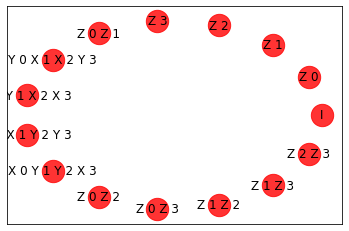

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 1905.23it/s]


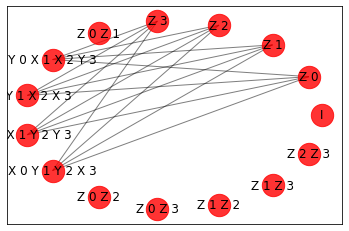

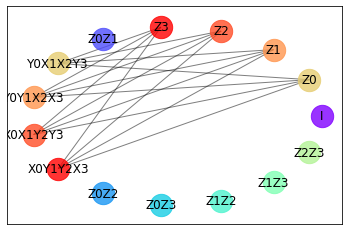

{0: [(-0.09706626861762581+0j) []],
 1: [(0.168688981686933+0j) [Z0 Z1]],
 2: [(0.12062523481381841+0j) [Z0 Z2]],
 3: [(0.16592785032250779+0j) [Z0 Z3]],
 4: [(0.16592785032250779+0j) [Z1 Z2]],
 5: [(0.12062523481381841+0j) [Z1 Z3]],
 6: [(0.1744128761065161+0j) [Z2 Z3]],
 7: [(0.17141282639402383+0j) [Z0], (0.045302615508689394+0j) [Y0 X1 X2 Y3]],
 8: [(0.1714128263940239+0j) [Z1], (-0.045302615508689394+0j) [Y0 Y1 X2 X3]],
 9: [(-0.22343153674663985+0j) [Z2], (-0.045302615508689394+0j) [X0 X1 Y2 Y3]],
 10: [(-0.22343153674663985+0j) [Z3], (0.045302615508689394+0j) [X0 Y1 Y2 X3]]}

In [17]:
x = Openfermion_Hamiltonian_Graph(QubitHamiltonian)
commutativity_flag = 'AC'
x.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy='largest_first', plot_graph=True)

## need todo this part!!

# Looking at relationships between these sets!

In [18]:
from quchem.Hamiltonian_Generator_Functions import *


### HAMILTONIAN start
Molecule = 'LiH'
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., 1.45))]
num_shots = 10000
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

### GRAPH start
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'

set_defined_by_comm_flag = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)

Building Graph Edges: 100%|##########| 631/631 [00:20<00:00, 30.34it/s] 


## Graph_of_two_sets

In [ ]:
anti_comm_QWC = 'C'
plot_graph = True

i=20
j=15
print([' '.join([t[1]+str(t[0]) for t in list(Op.terms.keys())[0]]) for Op in set_defined_by_comm_flag[i] ])
print('')
print([' '.join([t[1]+str(t[0]) for t in list(Op.terms.keys())[0]]) for Op in set_defined_by_comm_flag[j] ])

print('')
print('')
Graph_of_two_sets_CONNECTED(set_defined_by_comm_flag[i], set_defined_by_comm_flag[j], anti_comm_QWC, plot_graph=plot_graph)

##

## Get all subgraphs

In [ ]:
anti_comm_QWC='C'

GRAPH_key_nodes, single_nodes = Get_subgraph_of_sets(set_defined_by_comm_flag, anti_comm_QWC, plot_graph=True, plot_sub_graphs=False)

In [ ]:
print(GRAPH_key_nodes.edges)

In [ ]:
taken_indices=[]
unqiue_terms =[]
for a,b in GRAPH_key_nodes.edges:
    if a not in taken_indices and b not in taken_indices:
        unqiue_terms.append((a,b))
        taken_indices.append(a)
        taken_indices.append(b)
print(len(unqiue_terms))
unqiue_terms

In [ ]:
# can check using:

anti_comm_QWC = 'C'
plot_graph = True

i=71
j=72
print([' '.join([t[1]+str(t[0]) for t in list(Op.terms.keys())[0]]) for Op in set_defined_by_comm_flag[i] ])
print('')
print([' '.join([t[1]+str(t[0]) for t in list(Op.terms.keys())[0]]) for Op in set_defined_by_comm_flag[j] ])

print('')
print('')
Graph_of_two_sets_CONNECTED(set_defined_by_comm_flag[i], set_defined_by_comm_flag[j], anti_comm_QWC, plot_graph=plot_graph)

In [ ]:
from quchem.Hamiltonian_Generator_Functions import *
### HAMILTONIAN start
Molecule = 'LiH'
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., 1.45))]
num_shots = 10000
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

#####################################
### GRAPH start
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'

set_defined_by_comm_flag = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)



print('No of terms in Hamiltonian reduced from {} to {} (reduction={})'.format(len(Hamiltonian_graph_obj.QubitHamiltonianFrozen),
                                                                               len(set_defined_by_comm_flag),
                                                                               len(Hamiltonian_graph_obj.QubitHamiltonianFrozen)- len(set_defined_by_comm_flag)))



sub_graph_relationship = 'C'

SubGraph_of_set_keys, keys_of_single_QubitOp = Get_subgraph_of_sets(set_defined_by_comm_flag, sub_graph_relationship, plot_graph=True)

print('Number of completely commuting sets (non-unique) in reduced Hamiltonian: ', len(SubGraph_of_set_keys.edges))
## note edges show sets that completely commute
# GG has nodes of all qubitOps in AC_set_dict_list with length greater than 1

## get clique cover of sub graph AKA UNIQUE sets:
coloured_sub_graph = Openfermion_Get_clique_cover(SubGraph_of_set_keys)
## coloured_sub_graph shows what we do in experiment! WITH the single ops too: keys_of_single_QubitOp!!!
# NOTE coloured_sub_graph only contains terms with more than one qubitOperator


print('Number of completely UNIQUE commuting sets in reduced Hamiltonian= {}'.format(len([coloured_sub_graph[key] for key in coloured_sub_graph if len(coloured_sub_graph[key]) >1])))
print('THESE can be measured SIMULTANEOUSLY')

# print('Number of anti_commuting_set reductions that can be done SIMULTANEOUSLY:',
#       (len(AC_set_dict_list) - len(keys_of_single_QubitOp)) - len(
#           coloured_sub_graph))


# note coloured_sub_graph only contains indices of terms with more than one qubitOp in it...
# hence minus keys_of_single_QubitOp

# print('overall no. terms to measure: ', len(coloured_sub_graph) + len(keys_of_single_QubitOp))

print('No of terms in reduced Hamiltonian reduced = {} BUT only requires to {} measurements'.format(
    len(set_defined_by_comm_flag),
    len(coloured_sub_graph) + len(keys_of_single_QubitOp)))

In [ ]:
print('No of terms in Hamiltonian reduced from {} to {} (reduction={})'.format(len(Hamiltonian_graph_obj.QubitHamiltonianFrozen),
                                                                               len(set_defined_by_comm_flag),
                                                                               len(Hamiltonian_graph_obj.QubitHamiltonianFrozen)- len(set_defined_by_comm_flag)))

print('Number of completely commuting sets (non-unique) in reduced Hamiltonian: ', len(SubGraph_of_set_keys.edges))
      
print('Number of completely UNIQUE commuting sets in reduced Hamiltonian= {}'.format(len([coloured_sub_graph[key] for key in coloured_sub_graph if len(coloured_sub_graph[key]) >1])))
print('THESE can be measured SIMULTANEOUSLY')
      
print('No of terms in reduced Hamiltonian reduced = {} BUT only requires to {} measurements'.format(
    len(set_defined_by_comm_flag),
    len(coloured_sub_graph) + len(keys_of_single_QubitOp)))

In [ ]:
print('single terms')
print(keys_of_single_QubitOp)

print('')
print('each key gives keys of sets that can be measured at same time!')
coloured_sub_graph

In [ ]:
taken_indices=[]
unqiue_terms =[]
for a,b in SubGraph_of_set_keys.edges:
    if a not in taken_indices and b not in taken_indices:
        unqiue_terms.append((a,b))
        taken_indices.append(a)
        taken_indices.append(b)
print(len(unqiue_terms))
unqiue_terms

In [ ]:
# can check using:

anti_comm_QWC = 'C'
plot_graph = True

i=21
j=27
print([' '.join([t[1]+str(t[0]) for t in list(Op.terms.keys())[0]]) for Op in set_defined_by_comm_flag[i] ])
print('')
print([' '.join([t[1]+str(t[0]) for t in list(Op.terms.keys())[0]]) for Op in set_defined_by_comm_flag[j] ])

print('')
print('')
Graph_of_two_sets_CONNECTED(set_defined_by_comm_flag[i], set_defined_by_comm_flag[j], anti_comm_QWC, plot_graph=plot_graph)

# Class method!

In [ ]:
red_Ham = Hamiltonian_Graph_reduction(QubitHamiltonian, 'AC', Graph_colouring_strategy='largest_first',
                 plot_qubit_Hamiltonian_relation_graph=False)

In [ ]:
Coloured_graph_of_subgraph_set_keys, keys_of_single_QubitOps = red_Ham.Get_Coloured_graph_of_subgraphs('C')

### Checking with H2

In [ ]:
from quchem.Hamiltonian_Generator_Functions import *
### HAMILTONIAN start
Molecule = 'H2'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
num_shots = 10000
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

#####################################
### GRAPH start
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'

set_defined_by_comm_flag = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)



print('No of terms in Hamiltonian reduced from {} to {} (reduction={})'.format(len(Hamiltonian_graph_obj.QubitHamiltonianFrozen),
                                                                               len(set_defined_by_comm_flag),
                                                                               len(Hamiltonian_graph_obj.QubitHamiltonianFrozen)- len(set_defined_by_comm_flag)))



sub_graph_relationship = 'C'

SubGraph_of_set_keys, keys_of_single_QubitOp = Get_subgraph_of_sets(set_defined_by_comm_flag, sub_graph_relationship, plot_graph=True)

print('Number of completely commuting sets (non-unique) in reduced Hamiltonian: ', len(SubGraph_of_set_keys.edges))
## note edges show sets that completely commute
# GG has nodes of all qubitOps in AC_set_dict_list with length greater than 1

## get clique cover of sub graph AKA UNIQUE sets:
coloured_sub_graph = Openfermion_Get_clique_cover(SubGraph_of_set_keys)
## coloured_sub_graph shows what we do in experiment! WITH the single ops too: keys_of_single_QubitOp!!!
# NOTE coloured_sub_graph only contains terms with more than one qubitOperator


print('Number of completely UNIQUE commuting sets in reduced Hamiltonian= {}'.format(len([coloured_sub_graph[key] for key in coloured_sub_graph if len(coloured_sub_graph[key]) >1])))
print('THESE can be measured SIMULTANEOUSLY')

# print('Number of anti_commuting_set reductions that can be done SIMULTANEOUSLY:',
#       (len(AC_set_dict_list) - len(keys_of_single_QubitOp)) - len(
#           coloured_sub_graph))


# note coloured_sub_graph only contains indices of terms with more than one qubitOp in it...
# hence minus keys_of_single_QubitOp

# print('overall no. terms to measure: ', len(coloured_sub_graph) + len(keys_of_single_QubitOp))

print('No of terms in reduced Hamiltonian reduced = {} BUT only requires to {} measurements'.format(
    len(set_defined_by_comm_flag),
    len(coloured_sub_graph) + len(keys_of_single_QubitOp)))

print('')
print('key defines which sets can be measured at same time!', coloured_sub_graph)

In [ ]:
taken_indices=[]
unqiue_terms =[]
for a,b in SubGraph_of_set_keys.edges:
    if a not in taken_indices and b not in taken_indices:
        unqiue_terms.append((a,b))
        taken_indices.append(a)
        taken_indices.append(b)
print(len(unqiue_terms))
unqiue_terms